<a href="https://colab.research.google.com/github/kollerbud/resume-rec/blob/main/src/notebooks/7406_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
import shutil
os.makedirs('/root/.kaggle', exist_ok=True)
shutil.copy('/content/drive/MyDrive/georgia Tech/7406/HW5/kaggle.json', '/root/.kaggle/kaggle.json')
os.chmod('/root/.kaggle/kaggle.json', 600)

Mounted at /content/drive


In [2]:
# arshkon/linkedin-job-postings
# snehaanbhawal/resume-dataset

In [3]:
import kagglehub
import kaggle
kaggle.api.dataset_download_files('arshkon/linkedin-job-postings', path='/content/job_post/', unzip=True)
kaggle.api.dataset_download_files('snehaanbhawal/resume-dataset', path='/content/resume/', unzip=True)

Dataset URL: https://www.kaggle.com/datasets/arshkon/linkedin-job-postings
Dataset URL: https://www.kaggle.com/datasets/snehaanbhawal/resume-dataset


In [4]:
import polars as pl
import duckdb
from bs4 import BeautifulSoup
import re
import nltk
from nltk.corpus import stopwords, wordnet
from string import punctuation
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
sql_statement = """
  SELECT postings.*, industry.industry_name
  FROM (
    SELECT *
    FROM read_csv_auto('job_post/postings.csv', ignore_errors=true)
  ) AS postings
  LEFT JOIN (
    SELECT job_id, industry_id
    FROM read_csv_auto('job_post/jobs/job_industries.csv')
  ) AS job_industries
  ON postings.job_id = job_industries.job_id
  LEFT JOIN (
    SELECT industry_id, industry_name
    FROM read_csv_auto('job_post/mappings/industries.csv')
  ) AS industry
  ON job_industries.industry_id = industry.industry_id
  ;
"""
df_post = duckdb.sql(sql_statement).pl()

In [6]:
df_post.head()

job_id,company_name,title,description,max_salary,pay_period,location,company_id,views,med_salary,min_salary,formatted_work_type,applies,original_listed_time,remote_allowed,job_posting_url,application_url,application_type,expiry,closed_time,formatted_experience_level,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type,normalized_salary,zip_code,fips,industry_name
i64,str,str,str,f64,str,str,f64,f64,f64,f64,str,f64,f64,f64,str,str,str,f64,f64,str,str,f64,str,i64,str,str,str,f64,str,str,str
3885109867,"""Yoh, A Day & Zimmermann Compan…","""Trading Desk Tech Support Anal…","""The Equities Trading Technolog…",95000.0,"""YEARLY""","""New York City Metropolitan Are…",6044.0,498.0,null,80000.0,"""Full-time""",49.0,1.7125e12,null,"""https://www.linkedin.com/jobs/…",null,"""ComplexOnsiteApply""",1.7150e12,null,"""Mid-Senior level""",null,1.7125e12,null,0,"""FULL_TIME""","""USD""","""BASE_SALARY""",87500.0,null,null,"""Financial Services"""
3885109872,"""Keep Toledo/Lucas County Beaut…","""Community Education Specialist""","""POSITION: Community Education …",41000.0,"""YEARLY""","""Toledo, Ohio Metropolitan Area""",4.9646747e7,13.0,null,37000.0,"""Full-time""",null,1.7125e12,null,"""https://www.linkedin.com/jobs/…",null,"""ComplexOnsiteApply""",1.7150e12,null,null,null,1.7125e12,null,0,"""FULL_TIME""","""USD""","""BASE_SALARY""",39000.0,null,null,"""Environmental Services"""
3885109879,"""SLCA North America""","""Intern""",""" The Student Led Chess Associa…",null,null,"""United States""",8.9513363e7,47.0,null,null,"""Volunteer""",4.0,1.7125e12,1.0,"""https://www.linkedin.com/jobs/…",null,"""SimpleOnsiteApply""",1.7150e12,null,null,null,1.7125e12,null,0,"""VOLUNTEER""",null,null,null,null,null,"""Education Administration Progr…"
3885109880,"""Saint Andrew's Episcopal Schoo…","""Middle School Learning Special…","""Saint Andrew’s Episcopal Schoo…",118000.0,"""YEARLY""","""Saratoga, CA""",914254.0,25.0,null,75000.0,"""Full-time""",1.0,1.7125e12,null,"""https://www.linkedin.com/jobs/…","""https://recruiting.paylocity.c…","""OffsiteApply""",1.7280e12,null,null,null,1.7125e12,null,0,"""FULL_TIME""","""USD""","""BASE_SALARY""",96500.0,"""95070""","""06085""","""Education Administration Progr…"
3885109950,"""Parsolvo""","""Chief Information Officer""","""Company Description Parsolvo…",null,null,"""Houston, TX""",6.466647e7,6.0,null,null,"""Contract""",null,1.7125e12,null,"""https://www.linkedin.com/jobs/…",null,"""SimpleOnsiteApply""",1.7151e12,null,null,null,1.7125e12,null,0,"""CONTRACT""",null,null,null,"""77002""","""48201""","""Computer and Network Security"""


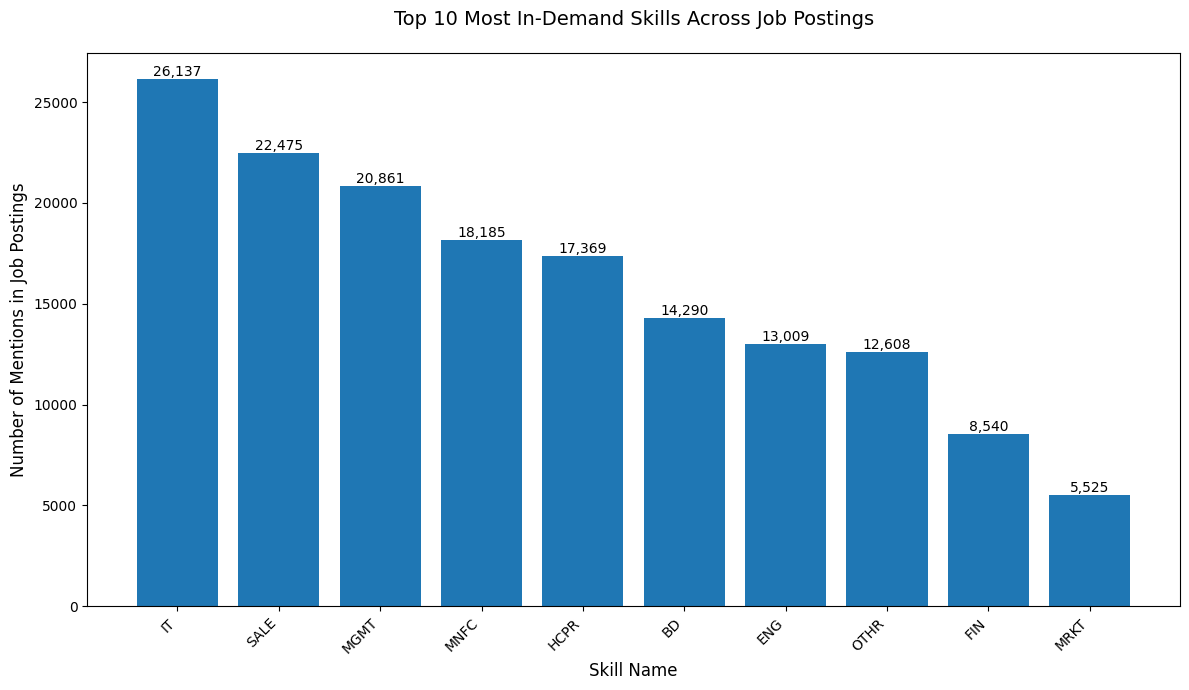

In [7]:
sql_statement = """
SELECT skill_abr, COUNT(*) as count
FROM read_csv_auto('job_post/jobs/job_skills.csv')
GROUP BY skill_abr
ORDER BY count DESC
LIMIT 10;
"""
top_skills = duckdb.sql(sql_statement).pl()

skill_names = top_skills['skill_abr'].to_list()
skill_counts = top_skills['count'].to_list()


plt.figure(figsize=(12, 7))

bars = plt.bar(skill_names, skill_counts)

plt.title('Top 10 Most In-Demand Skills Across Job Postings', fontsize=14, pad=20)
plt.xlabel('Skill Name', fontsize=12)
plt.ylabel('Number of Mentions in Job Postings', fontsize=12)


plt.xticks(rotation=45, ha='right')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}',
             ha='center', va='bottom')

plt.tight_layout()

plt.show()

<ipython-input-8-54a90e010f07>:1: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  top_jobs = df_post.group_by('title').agg(pl.count().alias('count')).sort('count', descending=True).head(10)


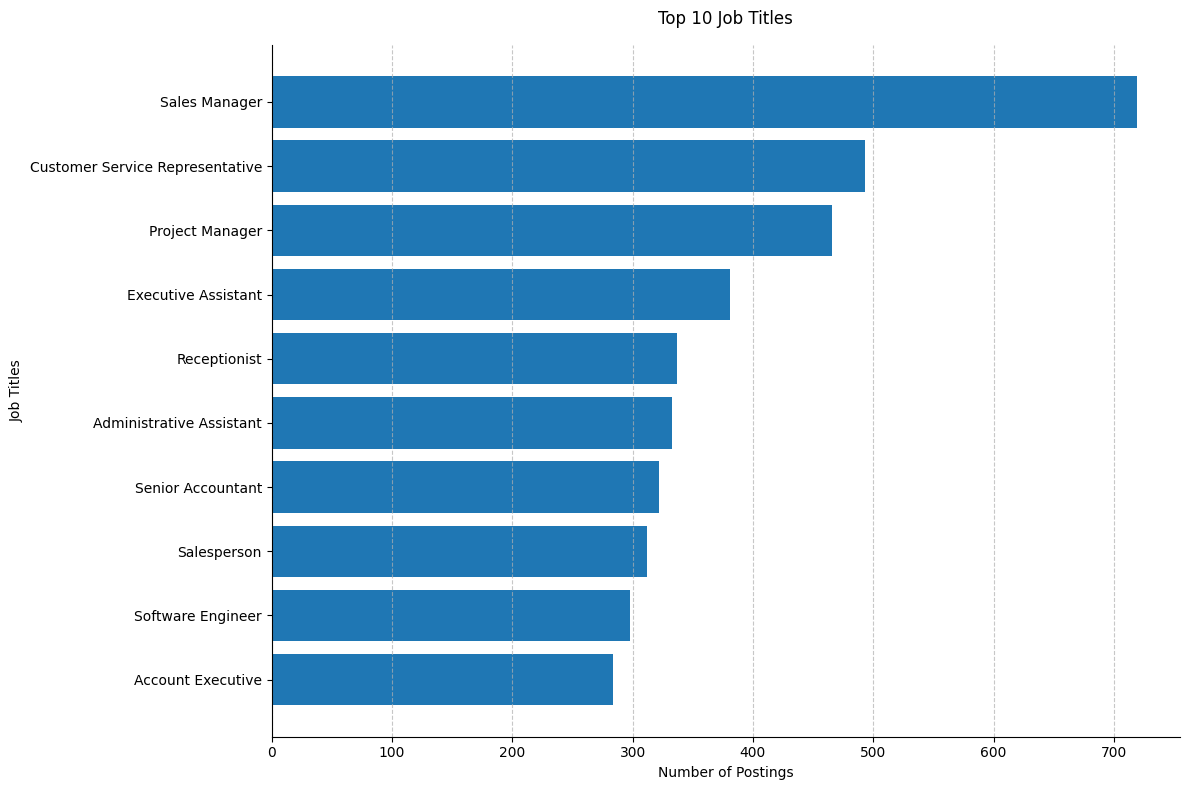

In [8]:
top_jobs = df_post.group_by('title').agg(pl.count().alias('count')).sort('count', descending=True).head(10)


plt.figure(figsize=(12, 8))
bars = plt.barh(top_jobs['title'].to_list()[::-1],
                top_jobs['count'].to_list()[::-1]
                )

plt.title('Top 10 Job Titles', pad=15)
plt.xlabel('Number of Postings')
plt.ylabel('Job Titles')


plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [9]:
#df_post['description'].sample(1).to_list()

In [10]:
# train_df = df.sample(fraction=0.8, with_replacement=False)
# test_df = df.filter(~pl.col('job_id').is_in(train_df['job_id']))
# test_job_id_df = test_df.select("job_id")  # Select the job_id column as a DataFrame
# test_job_id_df.write_csv("testset_job_id.csv")

In [11]:
sql_statement2 = """
SELECT *
FROM read_csv_auto('resume/Resume/Resume.csv')
"""
df_resume = duckdb.sql(sql_statement2).pl()

In [12]:
# df_resume['Resume_str'].sample(1).to_list()

In [13]:
# resume_train = []
# resume_test = []

# for _, group_df in df_resume.group_by('Category'):
#   train_sample = group_df.sample(fraction=0.8, with_replacement=False)
#   test_sample = group_df.filter(~pl.col('ID').is_in(train_sample['ID']))

#   resume_train.append(train_sample)
#   resume_test.append(test_sample)

# resume_train_df = pl.concat(resume_train)
# resume_test_df = pl.concat(resume_test)

In [14]:
# https://raw.githubusercontent.com/kollerbud/resume-rec/refs/heads/main/testset_job_id.csv?

In [15]:
def load_testID():
  # job posts test IDs
  # https://raw.githubusercontent.com/kollerbud/resume-rec/refs/heads/main/testset_job_id.csv
  posts_test_ids = pl.read_csv('https://raw.githubusercontent.com/kollerbud/resume-rec/refs/heads/main/testset_job_id.csv')

  # resumes test IDs
  # https://raw.githubusercontent.com/kollerbud/resume-rec/refs/heads/main/test_resume_id.csv
  resume_test_ids = pl.read_csv('https://raw.githubusercontent.com/kollerbud/resume-rec/refs/heads/main/test_resume_id.csv')

  return {
      'job_post': posts_test_ids,
      'resume': resume_test_ids
  }

In [16]:
# load trainset
def load_datasets(dataframe: pl.DataFrame, ID: pl.DataFrame, is_train: bool = True, id_col_name: str = "ID"):
    id_column = ID.columns[0]

    if is_train:
        filtered_df = dataframe.filter(~pl.col(id_col_name).is_in(ID[id_column]))
    else:
        filtered_df = dataframe.filter(pl.col(id_col_name).is_in(ID[id_column]))

    return filtered_df

In [17]:
IDs = load_testID()
job_posts_train = load_datasets(dataframe=df_post, ID=IDs['job_post'], is_train=True, id_col_name='job_id')
job_posts_test = load_datasets(dataframe=df_post, ID=IDs['job_post'], is_train=False, id_col_name='job_id')

resume_train = load_datasets(dataframe=df_resume, ID=IDs['resume'], is_train=True, id_col_name='ID')
resume_test = load_datasets(dataframe=df_resume, ID=IDs['resume'], is_train=False, id_col_name='ID')

In [18]:
#job_posts_train['description'].sample(1).to_list()

In [19]:
def keep_columns(dataset, keep_cols: list):

  dataset = dataset.select(keep_cols)

  return dataset

In [20]:
def clean_texts(text: str) -> str:

  if text is None or not isinstance(text, str):
    return ""

  # \n newlines and extra spaces
  text = re.sub(r'\s+', ' ', text)
  text = text.lower()
  # special characters and numbers
  text = re.sub(r'[^a-z\s]', '', text)
  return text

def clean_description(dataset: pl.DataFrame, descrp_col: str):

  clean_description = dataset.with_columns(
      pl.col(descrp_col).map_elements(clean_texts, return_dtype=pl.Utf8).alias(descrp_col)
  )
  return clean_description

In [21]:
stop_words = set(stopwords.words('english'))
extra_stopwords = {"we", "who", "us", "you", "they", "it", "he", "she", "this", "that", "our", "your", "their", "my", "me", "him", "her", "them"}
stop_words.update(extra_stopwords)

def extract_keywords(text: str) -> str:

    if text is None or not isinstance(text, str):
      return []

    keywords = [word for word in text.split() if word not in stop_words
                and word not in punctuation
                ]
    return keywords if keywords else []

def resume_extract_points(text: str) -> str:

  if text is None or not isinstance(text, str):
    return ""

  try:
    # parse with beautifulsoup
    soup = BeautifulSoup(text, 'html.parser')
    # p-tags
    p_texts = [p.get_text(strip=True) for p in soup.find_all('p')] # list
    # li-tags
    li_texts = [li.get_text(strip=True) for li in soup.find_all('li')] # list
    #combine
    all_text = p_texts + li_texts # list
    all_text = ' '.join(all_text)
    # clean texts
    all_text = clean_texts(all_text)

    return all_text
  except Exception as e:
    print(f'error processing job post {e}')
    return ""

In [22]:
def preprocessing(dataset, keep_cols, descrp_col: str, data_type: str='job_post'):

    df = dataset.select(keep_cols)

    if data_type == 'resume':
        # Process resumes
        df = df.with_columns([
            pl.col(descrp_col)
              .map_elements(resume_extract_points)
              .alias('cleaned_text')
        ])
        df = df.with_columns([
            pl.col('cleaned_text')
              .map_elements(extract_keywords, return_dtype=pl.List(pl.Utf8))
              .alias('keywords')
        ])
        # filter out None
        df = df.filter(
            (pl.col('keywords').is_not_null()) &
            (pl.col('keywords').list.len()>0)
        )

    else:
        # Process job posts
        df = df.with_columns([
            pl.col(descrp_col)
                .map_elements(clean_texts)
                .alias(descrp_col),
            pl.col(descrp_col)
                .map_elements(extract_keywords, return_dtype=pl.List(pl.Utf8))
                .alias('keywords')
        ])

        # filter out None
        df = df.filter(
            (pl.col('keywords').is_not_null()) &
            (pl.col('keywords').list.len()>0)
        )

    return df

In [23]:
df1 = preprocessing(dataset=df_post,
                    keep_cols=['job_id', 'company_name', 'title', 'description', 'industry_name'],
                    descrp_col='description')
df1.head() # df1 = job post test

sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.


job_id,company_name,title,description,industry_name,keywords
i64,str,str,str,str,list[str]
3885109867,"""Yoh, A Day & Zimmermann Compan…","""Trading Desk Tech Support Anal…","""the equities trading technolog…","""Financial Services""","[""The"", ""Equities"", … ""apply.""]"
3885109872,"""Keep Toledo/Lucas County Beaut…","""Community Education Specialist""","""position community education s…","""Environmental Services""","[""POSITION:"", ""Community"", … ""43612""]"
3885109879,"""SLCA North America""","""Intern""",""" the student led chess associa…","""Education Administration Progr…","[""The"", ""Student"", … ""consideration!""]"
3885109880,"""Saint Andrew's Episcopal Schoo…","""Middle School Learning Special…","""saint andrews episcopal school…","""Education Administration Progr…","[""Saint"", ""Andrew’s"", … ""check""]"
3885109950,"""Parsolvo""","""Chief Information Officer""","""company description parsolvo i…","""Computer and Network Security""","[""Company"", ""Description"", … ""field""]"


In [24]:
# x1 = df1['description'].sample(1).to_list()

In [25]:
def resume_extract_points(text: str) -> str:
  # parse with beautifulsoup
  soup = BeautifulSoup(text, 'html.parser')
  # p-tags
  p_texts = [p.get_text(strip=True) for p in soup.find_all('p')] # list
  # li-tags
  li_texts = [li.get_text(strip=True) for li in soup.find_all('li')] # list

  #combine
  all_text = p_texts + li_texts # list

  all_text = ' '.join(all_text)

  # clean texts
  all_text = clean_texts(all_text)

  return all_text

In [26]:
x2 = resume_train['Resume_html'].tail(2).to_list()
x22 = resume_extract_points(str(x2))
x22

'provided technical support in person and over the phone performed hardware and software installation and repair refurbished and setup pcs and peripheral devices performed shipping and receiving of product assisted with inventory management general logistics and warehouse duties assembled and tested tanks according to specifications maintained inventory of tools and supplies performed shipping and receiving duties performed troubleshooting and maintenance of aircraft performed ground handling and marshalling of aircraft performed daily safe for flight inspections maintaining and reconciling inventory through clerical support using peoplesoft to procure and receive shipments obtained by purchase order create excel spread sheets for reports manage inventory files and research inventory problems conduct inventory cycle counts coordinate stock and document transactions csr provide customer service to departmental and fleet maintenance personnel process work orders and fill fleet purchase r

In [27]:
df2 = preprocessing(dataset=resume_train, keep_cols=['ID', 'Resume_html', 'Category'], descrp_col='Resume_html', data_type='resume')

<ipython-input-22-d0e5aa9a8e1e>:7: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  df = df.with_columns([


<ipython-input-41-e388b46624a4>:1: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  top_resume_cat = df2.group_by('Category').agg(pl.count().alias('count')).sort('count', descending=True).head(2)


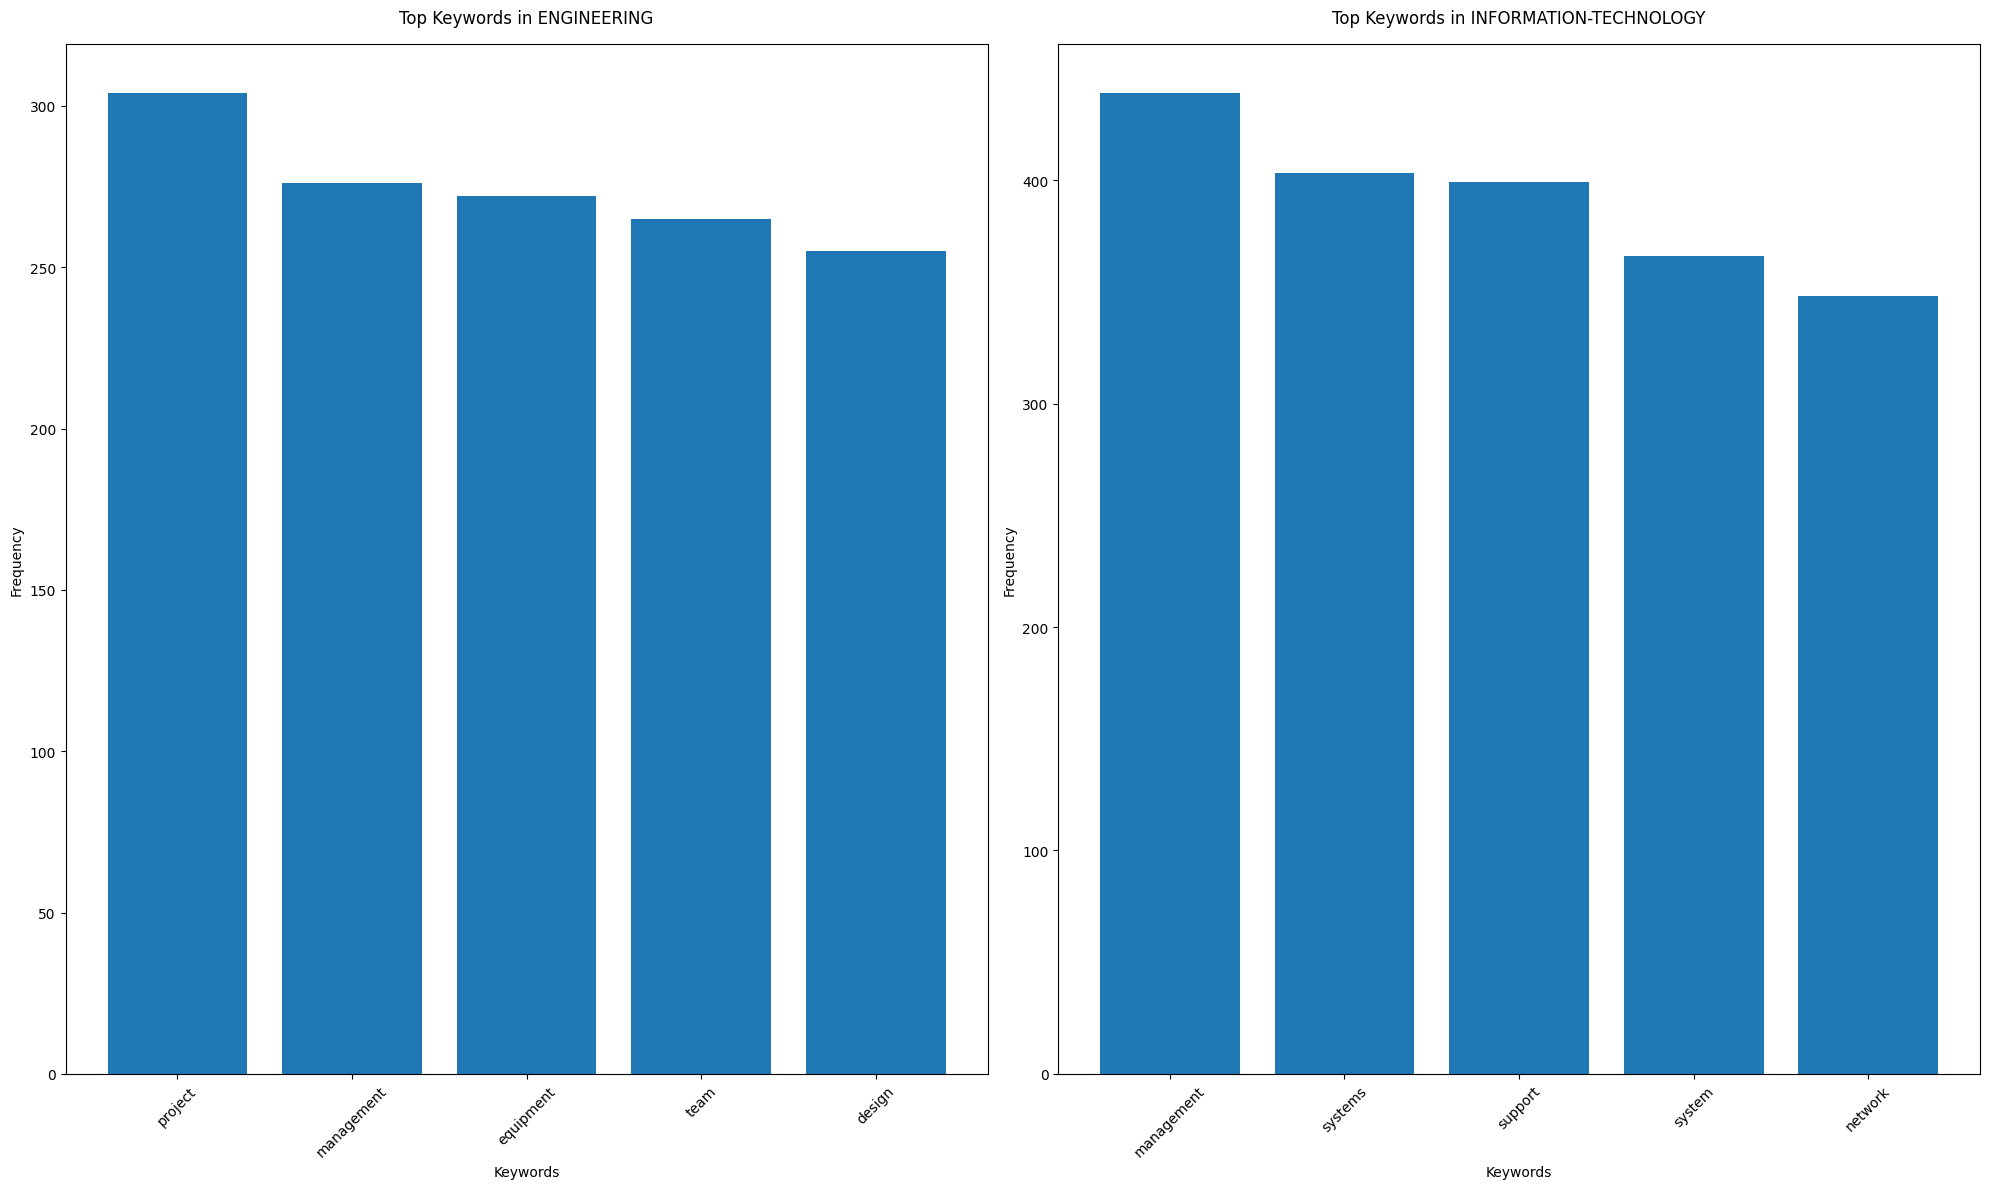

In [41]:
top_resume_cat = df2.group_by('Category').agg(pl.count().alias('count')).sort('count', descending=True).head(2)
top_resume_cat_names = top_resume_cat['Category'].to_list()

def get_top_keywords(df, category):
    category_keywords = df.filter(pl.col('Category') == category)
    all_keywords = pl.Series(name='keywords',
                           values=[word for sublist in category_keywords['keywords'].to_list()
                                 for word in sublist])
    keyword_counts = (all_keywords.value_counts()
                     .filter(pl.col('count') > 1)
                     .sort('count', descending=True)
                     .head(5))
    return keyword_counts

fig, axes = plt.subplots(1,2, figsize=(20,12))
axes = axes.flatten()

for idx, category in enumerate(top_resume_cat_names):
    # Get top keywords for this category
    keyword_counts = get_top_keywords(df2, category)

    ax = axes[idx]
    ax.bar(keyword_counts['keywords'].to_list(),
           keyword_counts['count'].to_list())

    ax.set_title(f'Top Keywords in {category}', pad=15)
    ax.set_xlabel('Keywords')
    ax.set_ylabel('Frequency')
    ax.tick_params(axis='x', rotation=45)


plt.tight_layout()
plt.show()

In [ ]:
# LDA modeling
import gensim
from gensim import models, corpora, similarities
import numpy as np

# https://radimrehurek.com/gensim/models/ldamodel.html


In [ ]:
def lda_recommender(job_data: pl.DataFrame, resume_data: pl.DataFrame, num_topics=20):
  # get keywords
  job_texts = job_data['keywords'].to_list()
  resume_texts = resume_data['keywords'].to_list()
  all_texts = job_texts + resume_texts
  # create dictionary
  dictionary = corpora.Dictionary(all_texts)
  # better filtering for performance
  dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=15000)
  # create corpus
  corpus = [dictionary.doc2bow(text) for text in all_texts]

  # LDA model
  # reduce accuracy for performance
  lda_model = models.LdaModel(
      corpus=corpus,
      id2word=dictionary,
      num_topics=num_topics,
      random_state=123,
      passes=2,
      alpha=50/num_topics,
      eta=0.1,
      chunksize=5000,
      iterations=50,
      eval_every=None,
      minimum_probability=0.0,
  )

  # transform documents to LDA space
  corpus_lda = [lda_model[doc] for doc in corpus]

  # create the similarity index
  index = similarities.MatrixSimilarity(
            corpus_lda,
            num_features=len(dictionary),
  )

  return {
      'dictionary': dictionary,
      'lda_model': lda_model,
      'sim_index': index,
      'job_corpus': corpus_lda[:len(job_texts)],
      'resume_corpus': corpus_lda[len(job_texts):]
  }

In [ ]:
def get_all_recommendations(job_data: pl.DataFrame,
                            resume_data: pl.DataFrame,
                            model,
                            top_k: int=1):

    all_sims = model['sim_index'][model['resume_corpus']]
    job_sims = all_sims[:, :len(job_data)]

    # top_idx
    top_idx = np.argpartition(job_sims, -top_k, axis=1)[:, -top_k:]
    top_sims = np.take_along_axis(job_sims, top_idx, axis=1)

    resume_ids = resume_data['ID'].to_list()
    resume_texts = resume_data['cleaned_text'].to_list()
    resume_categories = resume_data['Category'].to_list()
    job_ids = np.array(job_data['job_id'].to_list())[top_idx].flatten()
    job_titles = np.array(job_data['title'].to_list())[top_idx].flatten()
    companies = np.array(job_data['company_name'].to_list())[top_idx].flatten()
    job_descrp = np.array(job_data['description'].to_list())[top_idx].flatten()
    similarities = top_sims.flatten()

    recommendations_df = pl.DataFrame({
        'resume_idx': resume_ids,
        'resume_text': resume_texts,
        'resume_category': resume_categories,
        'job_idx': job_ids,
        'job_title': job_titles,
        'company': companies,
        'job_description': job_descrp,
        'similarity': similarities
    })
    return recommendations_df.sort('similarity', descending=True)

In [ ]:
model = lda_recommender(job_data=df1, resume_data=df2, num_topics=10)

In [ ]:
df_rec = get_all_recommendations(df1, df2, model, top_k=1)

In [ ]:
df_rec[:10]

resume_idx,resume_text,resume_category,job_idx,job_title,company,job_description,similarity
i64,str,str,i64,str,str,str,f32
36107065,"""httpswwwlinkedincomprofileview…","""PUBLIC-RELATIONS""",3901946283,"""Salesforce Developer""",null,"""ha vhk""",1.0
25834360,"""minor american history gpa he…","""HEALTHCARE""",3904952920,"""Nurse Practitioner Adolescent/…","""VCU Health""",""" sign on bonus for offers acc…",0.999767
79759716,"""microsoft word excel powerpoin…","""BUSINESS-DEVELOPMENT""",3891008792,"""Social Media Director""","""Robert Half""","""robert half has a client in ne…",0.999734
37792474,"""ensuring that all engineering …","""SALES""",3900965220,"""Construction Assistant Superin…","""Diamond Peak Recruiting""","""we are seeking a highly motiva…",0.999705
40883703,"""senior marketing manager partn…","""DIGITAL-MEDIA""",3903477558,"""Lead Generation Specialist""","""Chesapeake Search Partners""","""csp has partnered with a local…",0.999693
75435017,"""objective to obtain a rn posit…","""ADVOCATE""",3891007123,"""Registered Nurse - ED (PT Nigh…","""South Shore Health""","""if you are an existing employe…",0.999664
26958533,"""microsoft office suite expert …","""HEALTHCARE""",3887491173,"""Maintenance Technician Garland…","""Pregis""",""" maintenance labor maintenanc…",0.999635
15479281,"""coordinate all public relation…","""APPAREL""",3891008792,"""Social Media Director""","""Robert Half""","""robert half has a client in ne…",0.999591
46772262,"""registered nurse certified eme…","""ADVOCATE""",3901617501,"""Pediatric Registered Nurse II""","""Beth Israel Deaconess Medical …","""regularscheduled hourswork shi…",0.99957


In [ ]:
df_rec.write_csv('recommendation_list.csv')